In [28]:

# imports

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
import os

In [15]:
# check working directory

current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: /Users/gavinbarro/Documents/VT_programming/Fall_2025/CS-5805-Machine-Learning/CinemaSuccessSage/notebooks


In [16]:
#  Load and prepare data

train_df = pd.read_parquet('../data/processed/processed_train.parquet')
test_df = pd.read_parquet('../data/processed/processed_test.parquet')


# feature_cols = [col for col in train_df.columns if col not in ['revenue', 'rating']]

# Define feature columns (all except targets)
feature_cols = [col for col in train_df.columns if col not in ['revenue', 'rating']]

# Prune Features for Stability (to make pure Linear work)
var_thresh = VarianceThreshold(threshold=0.01)
train_var = var_thresh.fit_transform(train_df[feature_cols])
low_var_mask = var_thresh.get_support()
feature_cols_var = [feature_cols[i] for i in range(len(feature_cols)) if low_var_mask[i]]
print(f"Dropped {len(feature_cols) - len(feature_cols_var)} features (e.g., constant num_genres/num_cast).")

print("Dropped features:", [feature_cols[i] for i in range(len(feature_cols)) if not low_var_mask[i]])

#  Drop highly correlated (>0.8) to reduce collinearity
corr_matrix = pd.DataFrame(train_var, columns=feature_cols_var).corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
feature_cols_pruned = [col for col in feature_cols_var if col not in high_corr]
print(f"After correlation pruning: Dropped {len(feature_cols_var) - len(feature_cols_pruned)} highly correlated features.")

# Final features - keep core like budget, runtime, genres/seasons
feature_cols = feature_cols_pruned 

# revenue model
X_train_rev = train_df[feature_cols]
y_train_rev = train_df['revenue']  # log_revenue
X_test_rev = test_df[feature_cols]
y_test_rev = test_df['revenue']

# Rating model
X_train_rat = train_df[feature_cols]
y_train_rat = train_df['rating']  # avg_user_rating
X_test_rat = test_df[feature_cols]
y_test_rat = test_df['rating']

Dropped 35 features (e.g., constant num_genres/num_cast).
Dropped features: ['num__num_genres', 'num__num_cast', 'num__num_crew', 'cat__primary_genre_Unknown', 'cat__original_language_tmdb_cn', 'cat__original_language_tmdb_cs', 'cat__original_language_tmdb_da', 'cat__original_language_tmdb_de', 'cat__original_language_tmdb_el', 'cat__original_language_tmdb_es', 'cat__original_language_tmdb_et', 'cat__original_language_tmdb_fa', 'cat__original_language_tmdb_fi', 'cat__original_language_tmdb_he', 'cat__original_language_tmdb_hi', 'cat__original_language_tmdb_hu', 'cat__original_language_tmdb_id', 'cat__original_language_tmdb_it', 'cat__original_language_tmdb_iu', 'cat__original_language_tmdb_ja', 'cat__original_language_tmdb_ko', 'cat__original_language_tmdb_nb', 'cat__original_language_tmdb_nl', 'cat__original_language_tmdb_no', 'cat__original_language_tmdb_pl', 'cat__original_language_tmdb_pt', 'cat__original_language_tmdb_ro', 'cat__original_language_tmdb_ru', 'cat__original_language_

In [17]:
# Train Baseline for Revenue
model_rev = LinearRegression()
model_rev.fit(X_train_rev, y_train_rev)

# predict and evaluate
y_pred_rev = model_rev.predict(X_test_rev)
rmse_rev = np.sqrt(mean_squared_error(y_test_rev, y_pred_rev))
mae_rev = mean_absolute_error(y_test_rev, y_pred_rev)
r2_rev = r2_score(y_test_rev, y_pred_rev)

print("Revenue Baseline (Linear Regression) :")
print(f"RMSE: {rmse_rev:.4f}")
print(f"MAE: {mae_rev:.4f}")
print(f"R-squared: {r2_rev:.4f}")

# Interpret coefficients (top 5 positive/negative)
coef_df_rev = pd.DataFrame({'Feature': feature_cols, 'Coefficient': model_rev.coef_})
print("\nTop Coefficients for Revenue:")
print(coef_df_rev.sort_values('Coefficient', ascending=False).head(5)) 
print(coef_df_rev.sort_values('Coefficient').head(5))  # any negative impacts

Revenue Baseline (Linear Regression) :
RMSE: 1.4764
MAE: 1.0745
R-squared: 0.4438

Top Coefficients for Revenue:
                          Feature  Coefficient
0                num__budget_tmdb     0.774410
6  cat__original_language_tmdb_en     0.562615
2            num__popularity_tmdb     0.358047
4          num__user_rating_count     0.347918
5               num__release_year     0.196883
                           Feature  Coefficient
8         cat__release_season_Fall    -0.167111
9       cat__release_season_Spring    -0.062702
7   cat__original_language_tmdb_fr     0.036248
3             num__vote_count_tmdb     0.053282
10      cat__release_season_Summer     0.061382


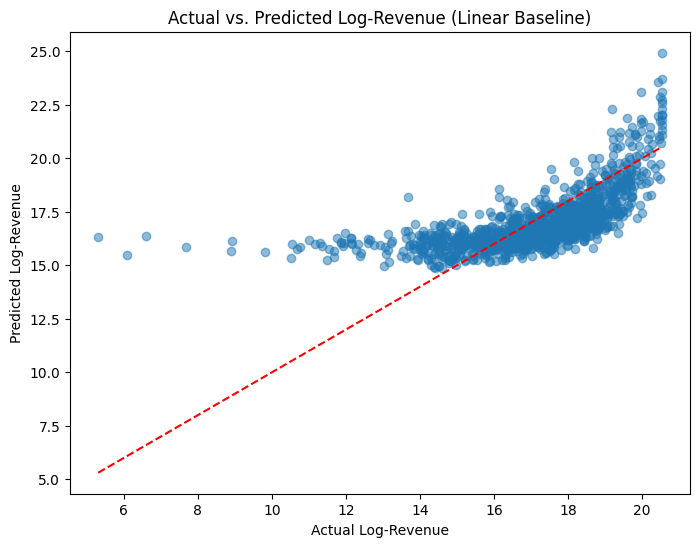

In [18]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_rev, y_pred_rev, alpha=0.5)
plt.plot([y_test_rev.min(), y_test_rev.max()], [y_test_rev.min(), y_test_rev.max()], 'r--')
plt.title('Actual vs. Predicted Log-Revenue (Linear Baseline)')
plt.xlabel('Actual Log-Revenue')
plt.ylabel('Predicted Log-Revenue')
plt.savefig('../reports/figures/revenue_actual_vs_pred_linear.png')
plt.show()

In [19]:
# Train for Ratings

model_rat = LinearRegression()
model_rat.fit(X_train_rat, y_train_rat)

y_pred_rat = model_rat.predict(X_test_rat)
rmse_rat = np.sqrt(mean_squared_error(y_test_rat, y_pred_rat))
mae_rat = mean_absolute_error(y_test_rat, y_pred_rat)
r2_rat = r2_score(y_test_rat, y_pred_rat)

print("Ratings Baseline (Linear Regression)")
print(f"RMSE: {rmse_rat:.4f}")
print(f"MAE: {mae_rat:.4f}")
print(f"R-squared: {r2_rat:.4f}")

coef_df_rat = pd.DataFrame({'Feature': feature_cols, 'Coefficient': model_rat.coef_})
print("Top Coefficients for Ratings:")
print(coef_df_rat.sort_values('Coefficient', ascending=False).head(5))
print("Bottom Coefficients for Ratings:")
print(coef_df_rat.sort_values('Coefficient').head(5))

Ratings Baseline (Linear Regression)
RMSE: 0.4103
MAE: 0.3214
R-squared: 0.3356
Top Coefficients for Ratings:
                          Feature  Coefficient
3            num__vote_count_tmdb     0.204430
1               num__runtime_tmdb     0.137270
7  cat__original_language_tmdb_fr     0.090482
4          num__user_rating_count     0.068126
8        cat__release_season_Fall     0.053070
Bottom Coefficients for Ratings:
                           Feature  Coefficient
6   cat__original_language_tmdb_en    -0.314370
0                 num__budget_tmdb    -0.137226
5                num__release_year    -0.066568
2             num__popularity_tmdb    -0.049698
10      cat__release_season_Summer    -0.042304


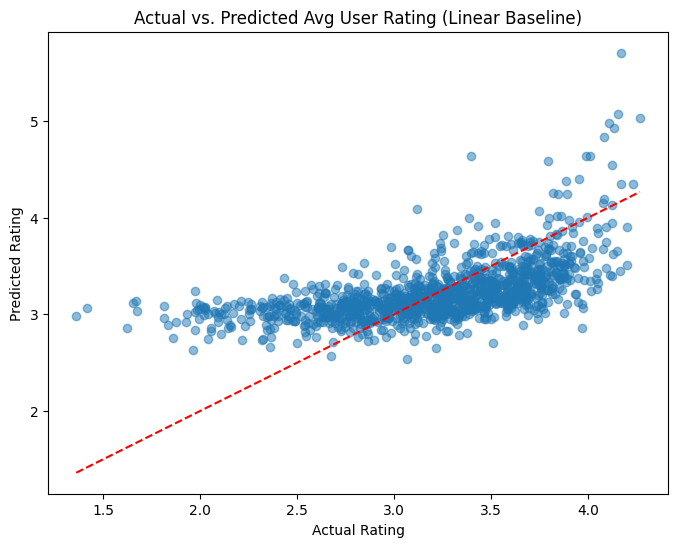

In [20]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_rat, y_pred_rat, alpha=0.5)
plt.plot([y_test_rat.min(), y_test_rat.max()], [y_test_rat.min(), y_test_rat.max()], 'r--')
plt.title('Actual vs. Predicted Avg User Rating (Linear Baseline)')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.savefig('../reports/figures/ratings_actual_vs_pred_linear.png')
plt.show()

In [31]:
# Save models

joblib.dump(model_rev, '../models/baseline_linear_revenue.pkl')
joblib.dump(model_rat, '../models/baseline_linear_rating.pkl')

# Log for report
print(f"\nFinal Features Used: {len(feature_cols)} (e.g., {feature_cols[:5]}...)")


Final Features Used: 12 (e.g., ['num__budget_tmdb', 'num__runtime_tmdb', 'num__popularity_tmdb', 'num__vote_count_tmdb', 'num__user_rating_count']...)


In [9]:
# BEGIN RANDOM FOREST

In [21]:
# Hyperparams: Start simple to prevent overfit, tune later
rf_params = {'n_estimators': 100, 'max_depth': 10, 'random_state': 42}

# Train RF for Revenue
rf_rev = RandomForestRegressor(**rf_params)
rf_rev.fit(X_train_rev, y_train_rev)

y_pred_rf_rev = rf_rev.predict(X_test_rev)
rmse_rf_rev = np.sqrt(mean_squared_error(y_test_rev, y_pred_rf_rev))
mae_rf_rev = mean_absolute_error(y_test_rev, y_pred_rf_rev)
r2_rf_rev = r2_score(y_test_rev, y_pred_rf_rev)

print("=== Revenue Random Forest ===")
print(f"RMSE: {rmse_rf_rev:.4f}")
print(f"MAE: {mae_rf_rev:.4f}")
print(f"R-squared: {r2_rf_rev:.4f}")

# Feature Importances (top 5)
import_df_rev = pd.DataFrame({'Feature': feature_cols, 'Importance': rf_rev.feature_importances_})
print("\nTop Feature Importances for Revenue:")
print(import_df_rev.sort_values('Importance', ascending=False).head(5))


=== Revenue Random Forest ===
RMSE: 1.2357
MAE: 0.8330
R-squared: 0.6104

Top Feature Importances for Revenue:
                  Feature  Importance
3    num__vote_count_tmdb    0.449140
0        num__budget_tmdb    0.299766
4  num__user_rating_count    0.083311
2    num__popularity_tmdb    0.054588
5       num__release_year    0.049347


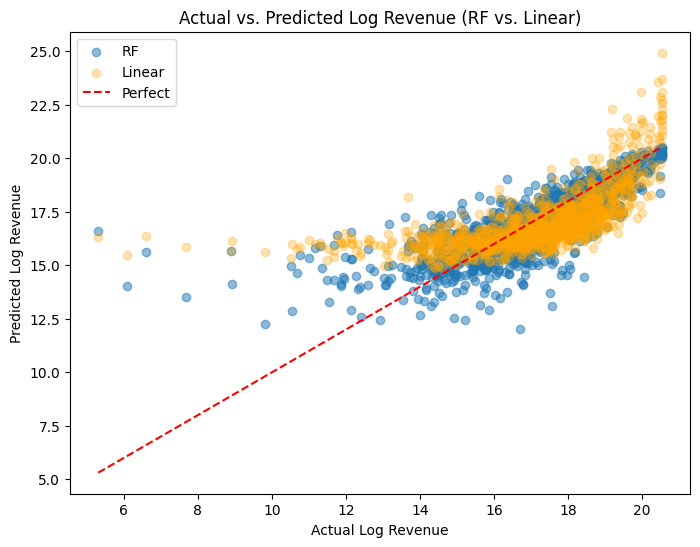

In [24]:
# Actual v Predicted Plot

plt.figure(figsize=(8, 6))
plt.scatter(y_test_rev, y_pred_rf_rev, alpha=0.5, label='RF')
plt.scatter(y_test_rev, model_rev.predict(X_test_rev), alpha=0.3, label='Linear', color='orange')  # Overlay baseline
plt.plot([y_test_rev.min(), y_test_rev.max()], [y_test_rev.min(), y_test_rev.max()], 'r--', label='Perfect')
plt.title('Actual vs. Predicted Log Revenue (RF vs. Linear)')
plt.xlabel('Actual Log Revenue')
plt.ylabel('Predicted Log Revenue')
plt.legend()
plt.savefig('../reports/figures/revenue_rf_vs_linear.png')
plt.show()

In [25]:
# Train RF for Ratings
rf_rat = RandomForestRegressor(**rf_params)
rf_rat.fit(X_train_rat, y_train_rat)

y_pred_rf_rat = rf_rat.predict(X_test_rat)
rmse_rf_rat = np.sqrt(mean_squared_error(y_test_rat, y_pred_rf_rat))
mae_rf_rat = mean_absolute_error(y_test_rat, y_pred_rf_rat)
r2_rf_rat = r2_score(y_test_rat, y_pred_rf_rat)

print("\n=== Ratings Random Forest ===")
print(f"RMSE: {rmse_rf_rat:.4f}")
print(f"MAE: {mae_rf_rat:.4f}")
print(f"R-squared: {r2_rf_rat:.4f}")

import_df_rat = pd.DataFrame({'Feature': feature_cols, 'Importance': rf_rat.feature_importances_})
print("\nTop Feature Importances for Ratings:")
print(import_df_rat.sort_values('Importance', ascending=False).head(5))


=== Ratings Random Forest ===
RMSE: 0.3392
MAE: 0.2602
R-squared: 0.5458

Top Feature Importances for Ratings:
                  Feature  Importance
4  num__user_rating_count    0.242672
0        num__budget_tmdb    0.224425
1       num__runtime_tmdb    0.194017
5       num__release_year    0.127961
3    num__vote_count_tmdb    0.099913


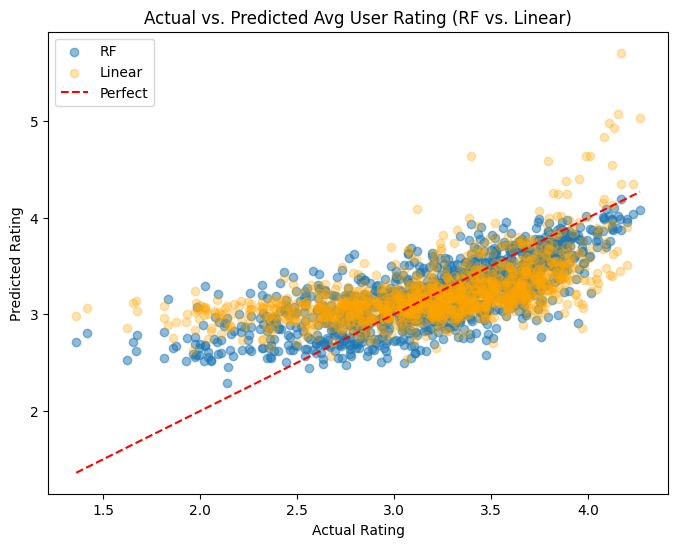

In [27]:
# Plot

plt.figure(figsize=(8, 6))
plt.scatter(y_test_rat, y_pred_rf_rat, alpha=0.5, label='RF')
plt.scatter(y_test_rat, model_rat.predict(X_test_rat), alpha=0.3, label='Linear', color='orange')
plt.plot([y_test_rat.min(), y_test_rat.max()], [y_test_rat.min(), y_test_rat.max()], 'r--', label='Perfect')
plt.title('Actual vs. Predicted Avg User Rating (RF vs. Linear)')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.legend()
plt.savefig('../reports/figures/ratings_rf_vs_linear.png')
plt.show()

In [33]:
# Comparison to Baseline (Table for Report)
comparison_df = pd.DataFrame({
    'Model': ['Linear', 'Random Forest'],
    'Revenue RMSE': [rmse_rev, rmse_rf_rev],
    'Revenue MAE': [mae_rev, mae_rf_rev],
    'Revenue R²': [r2_rev, r2_rf_rev],
    'Ratings RMSE': [rmse_rat, rmse_rf_rat],
    'Ratings MAE': [mae_rat, mae_rf_rat],
    'Ratings R²': [r2_rat, r2_rf_rat]
})
print("\nModel Comparison:")
print(comparison_df.round(4))
comparison_df.to_csv('../reports/rf_vs_linear_comparison.csv', index=False)

# Save RF models
joblib.dump(rf_rev, '../models/rf_revenue.pkl')
joblib.dump(rf_rat, '../models/rf_rating.pkl')


Model Comparison:
           Model  Revenue RMSE  Revenue MAE  Revenue R²  Ratings RMSE  \
0         Linear        1.4764       1.0745      0.4438        0.4103   
1  Random Forest        1.2357       0.8330      0.6104        0.3392   

   Ratings MAE  Ratings R²  
0       0.3214      0.3356  
1       0.2602      0.5458  


['../models/rf_rating.pkl']